# Start

In [214]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from matplotlib import pyplot as plt
import seaborn as sns
import ta, pandas_ta

from time_series_utils import df_apply_indicator, series_crossover, series_crossunder, rr_order_block, make_lags

from tqdm import tqdm
import logging
logging.getLogger().setLevel(logging.INFO)

pd.set_option('display.max_columns', 1000)

In [244]:
# import BTCUSDT data
bar_info, asset_pair = pd.read_csv(r".\backtest_data\BTCUSDT_1m.csv", index_col=0, parse_dates=True), 'BTCUSDT'
# import EURUSD data
# bar_info, asset_pair = pd.read_csv(r'.\backtest_data\mt4_eurusd.csv', index_col=0, parse_dates=True), 'EURUSD'

In [245]:
bar_info[bar_info.isna().any(axis=1)]

,Open,High,Low,Close,Volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
Timestamp,,,,,,,,,,,


In [246]:
# resample high to 60 minutes
ohlcv_agg = dict((
    ('Open', 'first'),
    ('High', 'max'),
    ('Low', 'min'),
    ('Close', 'last'),
    ('Volume', 'sum'),
    ))
# pd.plotting.autocorrelation_plot(X.resample('60T').agg(ohlcv_agg).iloc[:10000]['Close'])
# pd.plotting.autocorrelation_plot(result.resid.dropna())

# X Feature

In [247]:
X = bar_info.copy()
X = X.resample('30 min').agg(ohlcv_agg)

## Add ta indicators to DF

In [248]:
def df_apply_indicator(df, indicator, params, resample_period='5T'):
    '''resample to "resample_period", apply "indicator" passed in parameters and upsample to original frequency'''
    initial_freq = df.index.freq
    original_columns = df.columns.tolist()

    # resample to resample_period
    df = df.resample(resample_period).agg(ohlcv_agg)
    print(df.index.freq)
    
    # apply indicator function to dataframe
    df = indicator(df, **params)
    df.drop(original_columns, axis=1, inplace=True)
    
    # resample to original frequency and set timestamp to candle close
    df = df.shift(1).resample(initial_freq).ffill()
    df.columns = df.columns + '_' + resample_period
    
    return df

In [249]:
def series_apply_indicator(func, params, resample_period='5T'):
    '''resample to "resample_period", apply indicator passed in parameters and upsample to original frequency'''
    for key, series in params.items():
        try:
            if series.index.freq is None:
                raise ValueError(f"Series {key} has no frequency set")
        except Exception as e:
            print(e, series)
            continue

        initial_freq = series.index.freq
        
        # resample to resample_period
        params[key] = series.resample(resample_period).agg(ohlcv_agg[series.name])

    # apply indicator function to dataframe
    indicator_series = func(**params)
    
    # resample to original frequency and set timestamp to candle close
    indicator_series = indicator_series.shift(1).resample(initial_freq).ffill()
    indicator_series.name = indicator_series.name + '_' + resample_period

    return indicator_series

## reset

## Interpreted indicators

### pandas_ta

In [250]:
X.dropna(inplace=True)

In [251]:
# replace substrings in series with values in dictionary
def replace_substrings(series, substrings_dict):
    for key, value in substrings_dict.items():
        series = series.str.replace(key, value)
    return series

In [252]:
for category in X.ta.categories:
    X.ta.strategy(category, prefix=category)

X.columns = replace_substrings(X.columns.to_series(),dict(zip(pd.Series(X.ta.categories)+"_"+pd.Series(X.ta.categories), pd.Series(X.ta.categories)))).values

3it [00:07,  2.57s/it]
1it [00:01,  1.60s/it]
39it [00:11,  3.54it/s]
32it [00:12,  2.55it/s]
2it [00:01,  1.30it/s]
10it [00:02,  3.46it/s]
14it [00:07,  1.79it/s]
14it [00:03,  3.73it/s]
14it [00:03,  3.83it/s]


In [253]:
import talib as talib

In [254]:
# EMA de 20, 50, 100 if 20>50>100 long, if 20<50<100 short
for i in [20, 50, 100]:
    X[f"EMA_{i}"] = talib.EMA(X['Close'], i)

In [255]:
X['EMA_20_50_100'] = np.where((X['EMA_20'] > X['EMA_50']) & (X['EMA_50'] > X['EMA_100']), 1, np.where((X['EMA_20'] < X['EMA_50']) & (X['EMA_50'] < X['EMA_100']), -1, 0))

In [256]:
df = X.copy()

In [257]:
df["2crows"] = df["candles_CDL_2CROWS"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["3blackcrows"] = df["candles_CDL_3BLACKCROWS"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["3inside"] = df["candles_CDL_3INSIDE"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["3linestrike"] = df["candles_CDL_3LINESTRIKE"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["3outside"] = df["candles_CDL_3OUTSIDE"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["3starsinsouth"] = df["candles_CDL_3STARSINSOUTH"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["3whitesoldiers"] = df["candles_CDL_3WHITESOLDIERS"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["abandonedbaby"] = df["candles_CDL_ABANDONEDBABY"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["advanceblock"] = df["candles_CDL_ADVANCEBLOCK"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["belthold"] = df["candles_CDL_BELTHOLD"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["breakaway"] = df["candles_CDL_BREAKAWAY"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["closingmarubozu"] = df["candles_CDL_CLOSINGMARUBOZU"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["concealbabyswall"] = df["candles_CDL_CONCEALBABYSWALL"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["counterattack"] = df["candles_CDL_COUNTERATTACK"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["darkcloudcover"] = df["candles_CDL_DARKCLOUDCOVER"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["doji"] = df["candles_CDL_DOJI_10_0.1"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["dojistar"] = df["candles_CDL_DOJISTAR"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["dragonflydoji"] = df["candles_CDL_DRAGONFLYDOJI"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["engulfing"] = df["candles_CDL_ENGULFING"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["eveningdojistar"] = df["candles_CDL_EVENINGDOJISTAR"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["eveningstar"] = df["candles_CDL_EVENINGSTAR"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["gapsidesidewhite"] = df["candles_CDL_GAPSIDESIDEWHITE"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["gravestonedoji"] = df["candles_CDL_GRAVESTONEDOJI"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["hammer"] = df["candles_CDL_HAMMER"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["hangingman"] = df["candles_CDL_HANGINGMAN"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["harami"] = df["candles_CDL_HARAMI"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["haramicross"] = df["candles_CDL_HARAMICROSS"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["highwave"] = df["candles_CDL_HIGHWAVE"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["hikkake"] = df["candles_CDL_HIKKAKE"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["hikkakemod"] = df["candles_CDL_HIKKAKEMOD"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["homingpigeon"] = df["candles_CDL_HOMINGPIGEON"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["identical3crows"] = df["candles_CDL_IDENTICAL3CROWS"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["inneck"] = df["candles_CDL_INNECK"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["inside"] = df["candles_CDL_INSIDE"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["invertedhammer"] = df["candles_CDL_INVERTEDHAMMER"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["kicking"] = df["candles_CDL_KICKING"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["kickingbylength"] = df["candles_CDL_KICKINGBYLENGTH"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["ladderbottom"] = df["candles_CDL_LADDERBOTTOM"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["longleggeddoji"] = df["candles_CDL_LONGLEGGEDDOJI"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["longline"] = df["candles_CDL_LONGLINE"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["marubozu"] = df["candles_CDL_MARUBOZU"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["matchinglow"] = df["candles_CDL_MATCHINGLOW"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["mathold"] = df["candles_CDL_MATHOLD"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["morningdojistar"] = df["candles_CDL_MORNINGDOJISTAR"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["morningstar"] = df["candles_CDL_MORNINGSTAR"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["onneck"] = df["candles_CDL_ONNECK"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["piercing"] = df["candles_CDL_PIERCING"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["rickshawman"] = df["candles_CDL_RICKSHAWMAN"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["risefall3methods"] = df["candles_CDL_RISEFALL3METHODS"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["separatinglines"] = df["candles_CDL_SEPARATINGLINES"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["shootingstar"] = df["candles_CDL_SHOOTINGSTAR"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["shortline"] = df["candles_CDL_SHORTLINE"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["spinningtop"] = df["candles_CDL_SPINNINGTOP"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["stalledpattern"] = df["candles_CDL_STALLEDPATTERN"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["sticksandwich"] = df["candles_CDL_STICKSANDWICH"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["takuri"] = df["candles_CDL_TAKURI"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["tasukigap"] = df["candles_CDL_TASUKIGAP"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["thrusting"] = df["candles_CDL_THRUSTING"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["tristar"] = df["candles_CDL_TRISTAR"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["unique3river"] = df["candles_CDL_UNIQUE3RIVER"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["upsidegap2crows"] = df["candles_CDL_UPSIDEGAP2CROWS"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["xsidegap3methods"] = df["candles_CDL_XSIDEGAP3METHODS"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
condition2 = (df["candles_HA_close"]<df["candles_HA_close"].shift(1)) & (df["Close"]<df["Close"].shift(1))
condition1= (df["candles_HA_close"]>df["candles_HA_close"].shift(1)) & (df["Close"]>df["Close"].shift(1))
df["Heikin-Ashi: ha"] = condition1.astype(int) - condition2.astype(int)
df["Z Score: cdl_z"] = df["candles_close_Z_30_1"].apply(lambda x: -1 if x > 2 else (1 if x < -2 else 0))
df["Even Better Sinewave: ebsw"] = df["cycles_EBSW_40_10"].apply(lambda x: -1 if x > 0.8 else (1 if x < -0.8 else 0))
df["Absolute Price Oscillator: apo"] = df["momentum_APO_12_26"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["Bias: bias"] = df["momentum_BIAS_SMA_26"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["Balance of Power: bop"] = df["momentum_BOP"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["BRAR: brar"] = (df["momentum_AR_26"]<df["momentum_BR_26"]).astype(int) - (df["momentum_AR_26"]>df["momentum_BR_26"]).astype(int)
df["Chande Forecast Oscillator: cfo"] = df["momentum_CFO_9"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["Center of Gravity: cg"] = df["momentum_CG_10"].apply(lambda x: -1 if x < -5.5 else (1 if x > -5.5 else 0))
df["Chande Momentum Oscillator: cmo"] = df["momentum_CMO_14"].apply(lambda x: -1 if x > 80 else (1 if x < -20 else 0))
df["Coppock Curve: coppock"] = df["momentum_COPC_11_14_10"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["Correlation Trend Indicator: cti"] = df["momentum_CTI_12"].apply(lambda x: -1 if x > 0.8 else (1 if x < -0.2 else 0))
df["Efficiency Ratio: er"] = df["momentum_ER_10"].apply(lambda x: -1 if x < 0.48 else (1 if x > 0.52 else 0))
condition1= (df["momentum_FISHERT_9_1"]<-2) & (df["momentum_FISHERT_9_1"]>df["momentum_FISHERTs_9_1"])
condition2 = (df["momentum_FISHERT_9_1"]>2) & (df["momentum_FISHERT_9_1"]<df["momentum_FISHERTs_9_1"])
df["Fisher Transform: fisher"] = condition1.astype(int) - condition2.astype(int)
df["Inertia: inertia"] = df["momentum_INERTIA_20_14"].apply(lambda x: -1 if x < 50 else (1 if x > 50 else 0))
condition1= (df["momentum_K_9_3"]<25) & (df["momentum_J_9_3"]>df["momentum_D_9_3"])
condition2 = (df["momentum_K_9_3"]>75) & (df["momentum_J_9_3"]<df["momentum_D_9_3"])
df["KDJ: kdj"] = condition1.astype(int) - condition2.astype(int)
condition1= (df["momentum_MACD_12_26_9"]>df["momentum_MACDs_12_26_9"]) & (df["momentum_MACDs_12_26_9"]>0) & (df["momentum_MACDh_12_26_9"]>0)
condition2 = (df["momentum_MACD_12_26_9"]<df["momentum_MACDs_12_26_9"]) & (df["momentum_MACDs_12_26_9"]<0) & (df["momentum_MACDh_12_26_9"]<0)
df["MACD f2"] = condition1.astype(int) - condition2.astype(int)
df["Momentum: mom"] = df["momentum_MOM_10"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
df["Pretty Good Oscillator: pgo"] = df["momentum_PGO_14"].apply(lambda x: -1 if x > 2 else (1 if x < -2 else 0))
condition1 = (df["momentum_PPOh_12_26_9"]>0) & (df["momentum_PPOs_12_26_9"]>0)
condition2 = (df["momentum_PPOh_12_26_9"]<0) & (df["momentum_PPOs_12_26_9"]<0)
df["PPO "] = condition1.astype(int) - condition2.astype(int)
df["Psychological Line: psl"] = df["momentum_PSL_12"].apply(lambda x: -1 if x < 50 else (1 if x > 50 else 0))
condition1 = (df["momentum_PVO_12_26_9"]>df["momentum_PVOs_12_26_9"]) & (df["momentum_PVO_12_26_9"]>0)
condition2 = (df["momentum_PVO_12_26_9"]<df["momentum_PVOs_12_26_9"]) & (df["momentum_PVO_12_26_9"]<0)
df["Percentage Volume Oscillator: pvo"] = condition1.astype(int) - condition2.astype(int)
condition1 = (df["momentum_QQE_14_5_4.236"]>df["momentum_QQE_14_5_4.236_RSIMA"]) & (df["momentum_QQE_14_5_4.236"]>50)
condition2 = (df["momentum_QQE_14_5_4.236"]<df["momentum_QQE_14_5_4.236_RSIMA"]) & (df["momentum_QQE_14_5_4.236"]<50)
df["Quantitative Qualitative Estimation: qqe"] = condition1.astype(int) - condition2.astype(int)
df["Relative Strength Xtra: rsx"] = df["momentum_RSX_14"].apply(lambda x: -1 if x > 70 else (1 if x < 30 else 0))
condition1 = (df["momentum_RVGI_14_4"]>df["momentum_RVGIs_14_4"]) & (df["momentum_RVGI_14_4"]>0)
condition2 = (df["momentum_RVGI_14_4"]<df["momentum_RVGIs_14_4"]) & (df["momentum_RVGI_14_4"]<0)
df["Relative Vigor Index: rvgi"] = condition1.astype(int) - condition2.astype(int)
condition1= (df["momentum_STC_10_12_26_0.5"]>df["momentum_STCstoch_10_12_26_0.5"] ) & (df["momentum_STCmacd_10_12_26_0.5"]>0) & (df["momentum_STC_10_12_26_0.5"]>80)
condition2 =( df["momentum_STC_10_12_26_0.5"]<df["momentum_STCstoch_10_12_26_0.5"]) & (df["momentum_STCmacd_10_12_26_0.5"]<0) & (df["momentum_STC_10_12_26_0.5"]<20)
df["Schaff Trend Cycle: stc f2"] = condition1.astype(int) - condition2.astype(int)
df["Slope: slope"] = df["momentum_SLOPE_1"].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
condition1 = (df["momentum_SMI_5_20_5"]>df["momentum_SMIs_5_20_5"]) & (df["momentum_SMI_5_20_5"]>0)
condition2 = (df["momentum_SMI_5_20_5"]<df["momentum_SMIs_5_20_5"]) & (df["momentum_SMI_5_20_5"]<0)
df["SMI Ergodic smi"] = condition1.astype(int) - condition2.astype(int)
# condition1 = (df["momentum_SQZ_20_2.0_20_1.5"]>DR3) & (DR3>0)
# condition2 = (df["momentum_SQZ_20_2.0_20_1.5"]<DR3) & (DR3<0)
# df["Squeeze: squeeze"] = condition1.astype(int) - condition2.astype(int)
condition1 = (df["momentum_STOCHk_14_3_3"]>df["momentum_STOCHd_14_3_3"]) & (df["momentum_STOCHk_14_3_3"]<20)
condition2 = (df["momentum_STOCHk_14_3_3"]<df["momentum_STOCHd_14_3_3"]) & (df["momentum_STOCHk_14_3_3"]>80)
df["Stochastic Oscillator: stoch"] = condition1.astype(int) - condition2.astype(int)
condition1 = (df["momentum_STOCHRSIk_14_14_3_3"]>df["momentum_STOCHRSId_14_14_3_3"]) & (df["momentum_STOCHRSIk_14_14_3_3"]<20)
condition2 = (df["momentum_STOCHRSIk_14_14_3_3"]<df["momentum_STOCHRSId_14_14_3_3"]) & (df["momentum_STOCHRSIk_14_14_3_3"]>80)
df["Stochastic RSI: stochrsi"] = condition1.astype(int) - condition2.astype(int)
condition1 = (df["momentum_TRIX_30_9"]>df["momentum_TRIXs_30_9"]) & (df["momentum_TRIX_30_9"]>0)
condition2 = (df["momentum_TRIX_30_9"]<df["momentum_TRIXs_30_9"]) & (df["momentum_TRIX_30_9"]<0)
df["Trix: trix"] = condition1.astype(int) - condition2.astype(int)
condition1 = (df["momentum_TSI_13_25_13"]>df["momentum_TSIs_13_25_13"]) & (df["momentum_TSI_13_25_13"]>0)
condition2 = (df["momentum_TSI_13_25_13"]<df["momentum_TSIs_13_25_13"]) & (df["momentum_TSI_13_25_13"]<0)
df["True strength index: tsi"] = condition1.astype(int) - condition2.astype(int)

In [258]:
X = df.copy()
X.shape

(36275, 380)

In [259]:
# keep columns with less than 10% of NaN values
X = X.iloc[:,(X.apply(pd.Series.isna).sum() / X.shape[0] < 0.1).values].copy()
# drop columns with infinite values
X = X.iloc[:,((X == np.inf).sum()<1).values].copy()

X.shape

(36275, 371)

## STOCH RSI Crossover

# Y feature

In [260]:
X.index.min(), X.index.max()

(Timestamp('2021-05-07 20:30:00'), Timestamp('2023-06-02 21:00:00'))

In [261]:
X = X.iloc[-10000:].copy()

In [262]:
# first possible y
win_size = 15
# highest increase ratio over lowest decrease. 
# Takes negative values if there is no decrease or no increase (i.e. if the highest is lower than the close or the lowest is higher than the close)
y = (X['High'].rolling(win_size).max().shift(-win_size) - X['Close']) / (X['Close'] - X['Low'].rolling(win_size).min().shift(-win_size) + 500)

# second possible y
# print(rr_order_block(X['Close'], X['High'], X['Low'], risk=0.01, ratio=4, lead=40).shape)
# y = rr_order_block(X['Close'], X['High'], X['Low'], risk=0.01, ratio=4, lead=40, ob_type='buy')
# (y).value_counts()


In [263]:
# X = X[(X[X.columns[X.columns.str.contains('distance')]].abs()<0.001).any(axis=1)| ob_filter].copy()
y = y.loc[X.index]
X.shape, y.shape

((10000, 371), (10000,))

# Train Test Split

In [264]:
y.isna().sum()

15

In [265]:
X.iloc[36000:].isna().tail(30).sum().iloc[350:400]

Correlation Trend Indicator: cti            0.0
Efficiency Ratio: er                        0.0
Fisher Transform: fisher                    0.0
Inertia: inertia                            0.0
KDJ: kdj                                    0.0
MACD f2                                     0.0
Momentum: mom                               0.0
Pretty Good Oscillator: pgo                 0.0
PPO                                         0.0
Psychological Line: psl                     0.0
Percentage Volume Oscillator: pvo           0.0
Quantitative Qualitative Estimation: qqe    0.0
Relative Strength Xtra: rsx                 0.0
Relative Vigor Index: rvgi                  0.0
Schaff Trend Cycle: stc f2                  0.0
Slope: slope                                0.0
SMI Ergodic smi                             0.0
Stochastic Oscillator: stoch                0.0
Stochastic RSI: stochrsi                    0.0
Trix: trix                                  0.0
True strength index: tsi                

In [266]:
y = y.dropna()
X=X.loc[y.index]
X = X.dropna()
y=y.loc[X.index]

## One-hot encode

In [267]:
X_transformed = X.copy()
X_bkp = X.copy()
X = X_bkp.copy()

In [268]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

# Identify categorical and continuous columns and set(X[col].unique()).issubset({-1, 0, 1})
categorical_columns = [col for col in X.columns if X[col].nunique() <= 10 ]
continuous_columns = [col for col in X.columns if col not in categorical_columns]

In [269]:
# One-hot encode the categorical variables
X_transformed = pd.get_dummies(X_transformed, columns=categorical_columns)

In [270]:
# scale continuous variables
scaler = StandardScaler()
X_transformed[continuous_columns] = scaler.fit_transform(X_transformed[continuous_columns])

print(X_transformed.shape)
X_transformed.head()

(9974, 583)


,Open,High,Low,Close,Volume,candles_open_Z_30_1,candles_high_Z_30_1,candles_low_Z_30_1,candles_close_Z_30_1,candles_HA_open,candles_HA_high,candles_HA_low,candles_HA_close,cycles_EBSW_40_10,momentum_AO_5_34,momentum_APO_12_26,momentum_BIAS_SMA_26,momentum_BOP,momentum_AR_26,momentum_BR_26,momentum_CCI_14_0.015,momentum_CFO_9,momentum_CG_10,momentum_CMO_14,momentum_COPC_11_14_10,momentum_CTI_12,momentum_ER_10,momentum_BULLP_13,momentum_BEARP_13,momentum_FISHERT_9_1,momentum_FISHERTs_9_1,momentum_INERTIA_20_14,momentum_K_9_3,momentum_D_9_3,momentum_J_9_3,momentum_KST_10_15_20_30_10_10_10_15,momentum_KSTs_9,momentum_MACD_12_26_9,momentum_MACDh_12_26_9,momentum_MACDs_12_26_9,momentum_MOM_10,momentum_PGO_14,momentum_PPO_12_26_9,momentum_PPOh_12_26_9,momentum_PPOs_12_26_9,momentum_PSL_12,momentum_PVO_12_26_9,momentum_PVOh_12_26_9,momentum_PVOs_12_26_9,momentum_QQE_14_5_4.236,momentum_QQE_14_5_4.236_RSIMA,momentum_ROC_10,momentum_RSI_14,momentum_RSX_14,momentum_RVGI_14_4,momentum_RVGIs_14_4,momentum_SLOPE_1,momentum_SMI_5_20_5,momentum_SMIs_5_20_5,momentum_SMIo_5_20_5,momentum_SQZ_20_2.0_20_1.5,momentum_SQZPRO_20_2.0_20_2_1.5_1,momentum_STC_10_12_26_0.5,momentum_STCmacd_10_12_26_0.5,momentum_STCstoch_10_12_26_0.5,momentum_STOCHk_14_3_3,momentum_STOCHd_14_3_3,momentum_STOCHRSIk_14_14_3_3,momentum_STOCHRSId_14_14_3_3,momentum_TRIX_30_9,momentum_TRIXs_30_9,momentum_TSI_13_25_13,momentum_TSIs_13_25_13,momentum_UO_7_14_28,momentum_WILLR_14,overlap_ALMA_10_6.0_0.85,overlap_DEMA_10,overlap_EMA_10,overlap_FWMA_10,overlap_HILO_13_21,overlap_HL2,overlap_HLC3,overlap_HMA_10,overlap_ISA_9,overlap_ISB_26,overlap_ITS_9,overlap_IKS_26,overlap_ICS_26,overlap_JMA_7_0,overlap_KAMA_10_2_30,overlap_LR_14,overlap_MCGD_10,overlap_MIDPOINT_2,overlap_MIDPRICE_2,overlap_OHLC4,overlap_PWMA_10,overlap_RMA_10,overlap_SINWMA_14,overlap_SMA_10,overlap_SSF_10_2,overlap_SUPERT_7_3.0,overlap_SWMA_10,overlap_T3_10_0.7,overlap_TEMA_10,overlap_TRIMA_10,overlap_VIDYA_14,overlap_VWAP_D,overlap_VWMA_10,overlap_WCP,overlap_WMA_10,overlap_ZL_EMA_10,performance_LOGRET_1,performance_PCTRET_1,statistics_ENTP_10,statistics_KURT_30,statistics_MAD_30,statistics_MEDIAN_30,statistics_QTL_30_0.5,statistics_SKEW_30,statistics_STDEV_30,statistics_TOS_STDEVALL_LR,statistics_TOS_STDEVALL_L_1,statistics_TOS_STDEVALL_U_1,statistics_TOS_STDEVALL_L_2,statistics_TOS_STDEVALL_U_2,statistics_TOS_STDEVALL_L_3,statistics_TOS_STDEVALL_U_3,statistics_VAR_30,statistics_ZS_30,trend_ADX_14,trend_DMP_14,trend_DMN_14,trend_AROOND_14,trend_AROONU_14,trend_AROONOSC_14,trend_CHOP_14_1_100,trend_CKSPl_10_3_20,trend_CKSPs_10_3_20,trend_LDECAY_5,trend_DPO_20,trend_PSARaf_0.02_0.2,trend_QS_10,trend_VHF_28,trend_VTXP_14,trend_VTXM_14,volatility_ABER_ZG_5_15,volatility_ABER_SG_5_15,volatility_ABER_XG_5_15,volatility_ABER_ATR_5_15,volatility_ACCBL_20,volatility_ACCBM_20,volatility_ACCBU_20,volatility_ATRr_14,volatility_BBL_5_2.0,volatility_BBM_5_2.0,volatility_BBU_5_2.0,volatility_BBB_5_2.0,volatility_BBP_5_2.0,volatility_DCL_20_20,volatility_DCM_20_20,volatility_DCU_20_20,volatility_HWM,volatility_HWU,volatility_HWL,volatility_KCLe_20_2,volatility_KCBe_20_2,volatility_KCUe_20_2,volatility_MASSI_9_25,volatility_NATR_14,volatility_PDIST,volatility_RVI_14,volatility_THERMO_20_2_0.5,volatility_THERMOma_20_2_0.5,volatility_TRUERANGE_1,volatility_UI_14,volume_AD,volume_ADOSC_3_10,volume_OBV,volume_OBV_min_2,volume_OBV_max_2,volume_OBVe_4,volume_OBVe_12,volume_CMF_20,volume_EFI_13,volume_KVO_34_55_13,volume_KVOs_34_55_13,volume_MFI_14,volume_NVI_1,volume_PVI_1,volume_PVOL,volume_PVT,EMA_20,EMA_50,EMA_100,candles_CDL_2CROWS_0.0,candles_CDL_3BLACKCROWS_-100.0,candles_CDL_3BLACKCROWS_0.0,candles_CDL_3INSIDE_-100.0,candles_CDL_3INSIDE_0.0,candles_CDL_3INSIDE_100.0,candles_CDL_3LINESTRIKE_-100.0,candles_CDL_3LINESTRIKE_0.0,candles_CDL_3LINESTRIKE_100.0,candles_CDL_3OUTSIDE_-100.0,candles_CDL_3OUTSIDE_0.0,candles_CDL_3OUTSIDE_100.0,candles_CDL_3STARSINSOUTH_0.0,candles_CDL_3WHITESOLDIERS_0.0,candles_CDL_3WHITESOLDIERS_100.0

# MODELS

## LGBM Regressor MODEL

In [271]:
X_transformed.columns = X_transformed.columns.str.replace('.','').values
X_transformed.columns = X_transformed.columns.str.replace('-','_neg_').values

C:\Users\juanm\AppData\Local\Temp\ipykernel_7392\806018570.py:1: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [272]:
# make lags for all variables

for col in X_transformed.columns:
    # X_transformed = make_lags(X_transformed[col], 10, name=col)
    X_transformed = X_transformed.merge(make_lags(X_transformed[col], 5, name=col), left_index=True, right_index=True)

# train test split


In [273]:
X_transformed.columns[X_transformed.columns.str.contains('EMA_20_50_100')]

Index(['EMA_20_50_100__neg_1', 'EMA_20_50_100_0', 'EMA_20_50_100_1',
       'EMA_20_50_100__neg_1_lag_1', 'EMA_20_50_100__neg_1_lag_2',
       'EMA_20_50_100__neg_1_lag_3', 'EMA_20_50_100__neg_1_lag_4',
       'EMA_20_50_100__neg_1_lag_5', 'EMA_20_50_100_0_lag_1',
       'EMA_20_50_100_0_lag_2', 'EMA_20_50_100_0_lag_3',
       'EMA_20_50_100_0_lag_4', 'EMA_20_50_100_0_lag_5',
       'EMA_20_50_100_1_lag_1', 'EMA_20_50_100_1_lag_2',
       'EMA_20_50_100_1_lag_3', 'EMA_20_50_100_1_lag_4',
       'EMA_20_50_100_1_lag_5'],
      dtype='object')

In [ ]:
X.shape

(4974, 371)

In [86]:
X_transformed.shape

(4974, 3492)

In [277]:
list(top_5_features)

['trend_DPO_20',
 'trend_DMN_14',
 'momentum_PGO_14',
 'candles_close_Z_30_1',
 'momentum_KSTs_9_lag_5']

In [185]:
import re
# X_transformed.loc[:,~((X_transformed.abs() == np.inf).sum()>0)].replace([np.inf, -np.inf], np.nan).dropna()
# .rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# .drop(columns=['Open', 'High', 'Low', 'Close'])
X_train, X_test, y_train, y_test = train_test_split(X_transformed[['trend_DPO_20',
 'trend_DMN_14',
 'momentum_PGO_14',
 'candles_close_Z_30_1',
 'momentum_KSTs_9'] + X_transformed.columns[X_transformed.columns.str.contains('EMA_20_50_100')].to_list()].rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)), y, test_size=0.2, shuffle=False)

In [186]:

# Assume df is your DataFrame and it includes 'time', 'Y', 'X1', 'X2'... columns

# Convert time into datetime
# df['time'] = pd.to_datetime(df['time'])

# Sort dataframe by time
# df.sort_values('time', inplace=True)

# Let's say 'X1', 'X2' are your predictor variables and 'Y' is your outcome variable
# X = df[['X1', 'X2']] # add more variables to the list as needed
# Y = df['Y']

# Split the data into training and testing sets
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create a LightGBM data matrix from the training set
lgb_train = lgb.Dataset(X_train.reset_index(drop=True), label=y_train.reset_index(drop=True), categorical_feature=X_train.columns[X_train.columns.str.contains('k_crossover_d') | X_train.columns.str.contains('k_crossunder_d')].to_list())


In [187]:
X_train.shape, y_train.shape, lgb_train.data.shape

((3979, 6), (3979,), (3979, 6))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
Feature Importances: 


c:\Users\juanm\anaconda3\envs\bcs-trade-bot\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



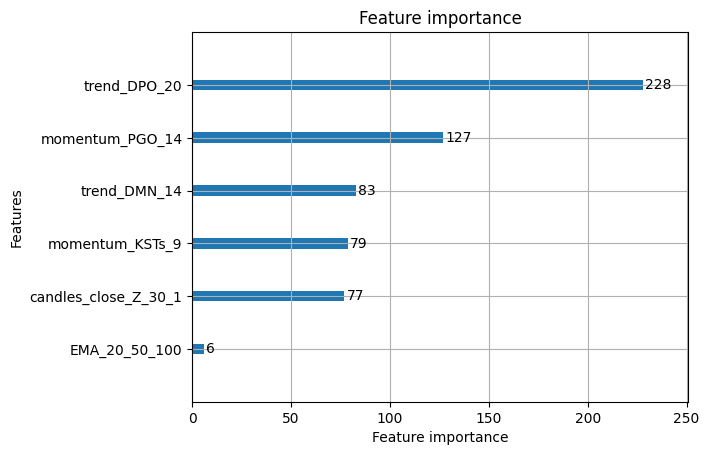

In [188]:

# Specify the configuration of the model
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the model
model = lgb.train(params,
                lgb_train,
                num_boost_round=20)

# Predict on the test set
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Print the feature importances
print('Feature Importances: ')
# for feature_name, importance_score in zip(X_train.columns, model.feature_importance()):
#     print(f'{feature_name}: {importance_score}')

# Plotting feature importances
lgb.plot_importance(model)
plt.show()

### metrics

In [142]:
# top_5_features = pd.Series(model.feature_importance(), X_train.columns).sort_values(ascending=False).head(5).index.values

In [189]:
pd.Series(model.feature_importance(), X_train.columns).sort_values(ascending=False).head(20)

trend_DPO_20            228
momentum_PGO_14         127
trend_DMN_14             83
momentum_KSTs_9          79
candles_close_Z_30_1     77
EMA_20_50_100             6
dtype: int32

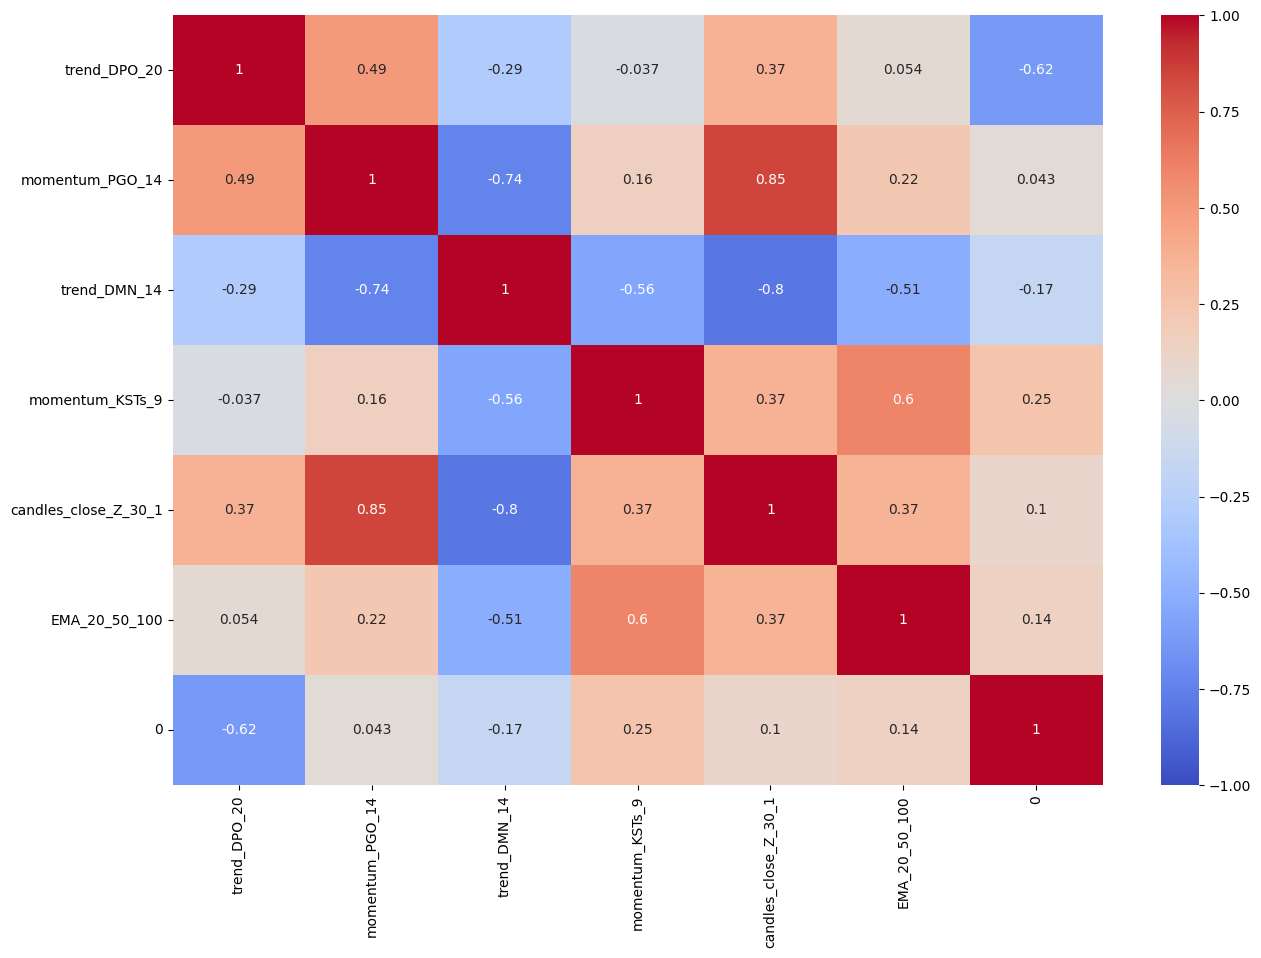

In [190]:
## plot correlation for 20 most important features
X_temp = pd.concat([X_train[pd.Series(model.feature_importance(), X_train.columns).sort_values(ascending=False).head(20).index.values].copy(), y_train], axis=1)

# Compute correlations
corr = X_temp.corr()

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [94]:
feature_importance_dict = dict(zip( X_train.columns, model.feature_importance()))
threshold = 0.8
columns_to_drop = set()

for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > threshold:  # if correlation is above threshold
            colname_i = corr.columns[i]  # get the name of the ith column
            colname_j = corr.columns[j]  # get the name of the jth column
            
            # drop the feature with the lower importance
            if feature_importance_dict[colname_i] >= feature_importance_dict[colname_j]:
                columns_to_drop.add(colname_j)
            else:
                columns_to_drop.add(colname_i)

columns_to_drop

{'candles_close_Z_30_1',
 'momentum_BEARP_13',
 'momentum_BULLP_13',
 'momentum_CMO_14',
 'trend_DMP_14'}

In [95]:
# drop feature importances equal to 0
columns_to_drop = columns_to_drop | set(X_train.columns[model.feature_importance()==0])

In [506]:
# X_transformed.drop(columns=columns_to_drop, inplace=True)

# PREDICTIONS Result

In [120]:
(X_test['EMA_20_50_100_1']==1).sum()

372

In [156]:
# append columns to list
X_transformed.columns[X_transformed.columns.str.contains('EMA_20_50_100')].to_list()

['EMA_20_50_100__neg_1',
 'EMA_20_50_100_0',
 'EMA_20_50_100_1',
 'EMA_20_50_100__neg_1_lag_1',
 'EMA_20_50_100__neg_1_lag_2',
 'EMA_20_50_100__neg_1_lag_3',
 'EMA_20_50_100__neg_1_lag_4',
 'EMA_20_50_100__neg_1_lag_5',
 'EMA_20_50_100_0_lag_1',
 'EMA_20_50_100_0_lag_2',
 'EMA_20_50_100_0_lag_3',
 'EMA_20_50_100_0_lag_4',
 'EMA_20_50_100_0_lag_5',
 'EMA_20_50_100_1_lag_1',
 'EMA_20_50_100_1_lag_2',
 'EMA_20_50_100_1_lag_3',
 'EMA_20_50_100_1_lag_4',
 'EMA_20_50_100_1_lag_5']

In [128]:
X_test.columns[X_test.columns.str.contains('EMA_20_50_100')]

Index(['EMA_20_50_100__neg_1', 'EMA_20_50_100_0', 'EMA_20_50_100_1',
       'EMA_20_50_100__neg_1_lag_1', 'EMA_20_50_100__neg_1_lag_2',
       'EMA_20_50_100__neg_1_lag_3', 'EMA_20_50_100__neg_1_lag_4',
       'EMA_20_50_100__neg_1_lag_5', 'EMA_20_50_100_0_lag_1',
       'EMA_20_50_100_0_lag_2', 'EMA_20_50_100_0_lag_3',
       'EMA_20_50_100_0_lag_4', 'EMA_20_50_100_0_lag_5',
       'EMA_20_50_100_1_lag_1', 'EMA_20_50_100_1_lag_2',
       'EMA_20_50_100_1_lag_3', 'EMA_20_50_100_1_lag_4',
       'EMA_20_50_100_1_lag_5'],
      dtype='object')

In [133]:
# model metrics for regression model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Make predictions on the test set
X_temp = X_test[X_test['EMA_20_50_100_1']==1].copy()
y_pred = model.predict(X_temp)
y_test_temp = y_test.loc[X_temp.index]


In [134]:
y_pred_temp = y_pred[(y_test_temp!=np.inf)]
y_test_temp = y_test_temp[(y_test_temp!=np.inf)]

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_temp, y_pred_temp)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_temp, y_pred_temp)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared (R²)
r2 = r2_score(y_test_temp, y_pred_temp)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 0.2969897600603326
Mean Squared Error (MSE): 0.1364853444266137
R-squared (R²): 0.18032387759708957


In [135]:
# model metrics for regression model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Make predictions on the test set
y_pred = model.predict(X_test)

y_pred_temp = y_pred[(y_test!=np.inf)]
y_test_temp = y_test[(y_test!=np.inf)]

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_temp, y_pred_temp)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_temp, y_pred_temp)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared (R²)
r2 = r2_score(y_test_temp, y_pred_temp)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 0.24701467379690117
Mean Squared Error (MSE): 0.09527587413997081
R-squared (R²): 0.1552219601114877


<Axes: xlabel='Timestamp'>

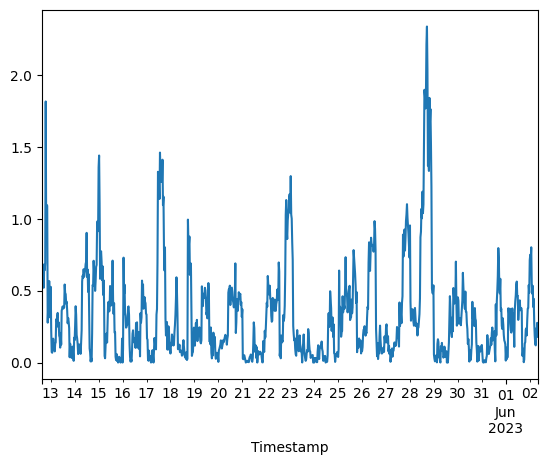

In [40]:
y_test.plot()

<Axes: xlabel='Timestamp'>

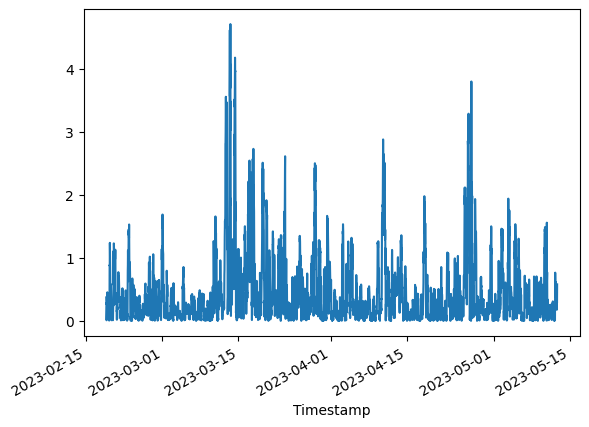

In [41]:
y_train.plot()

In [136]:
# plot Y_text with X axis time
mid_time = X_test.index.to_series().sample(1).values[0]
print(mid_time)
# start_time = X_test.index.to_series().sample(1).values[0]
start_time = mid_time-pd.Timedelta('3 hours')
end_time = start_time+pd.Timedelta('30 hours')


# candle plot of price for given time
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure(data=[go.Candlestick(x=X.loc[start_time:end_time].index,
                open=X.loc[start_time:end_time, 'Open'],
                high=X.loc[start_time:end_time, 'High'],
                low=X.loc[start_time:end_time, 'Low'],
                close=X.loc[start_time:end_time, 'Close'])])

fig.show()


2023-05-29T22:00:00.000000000


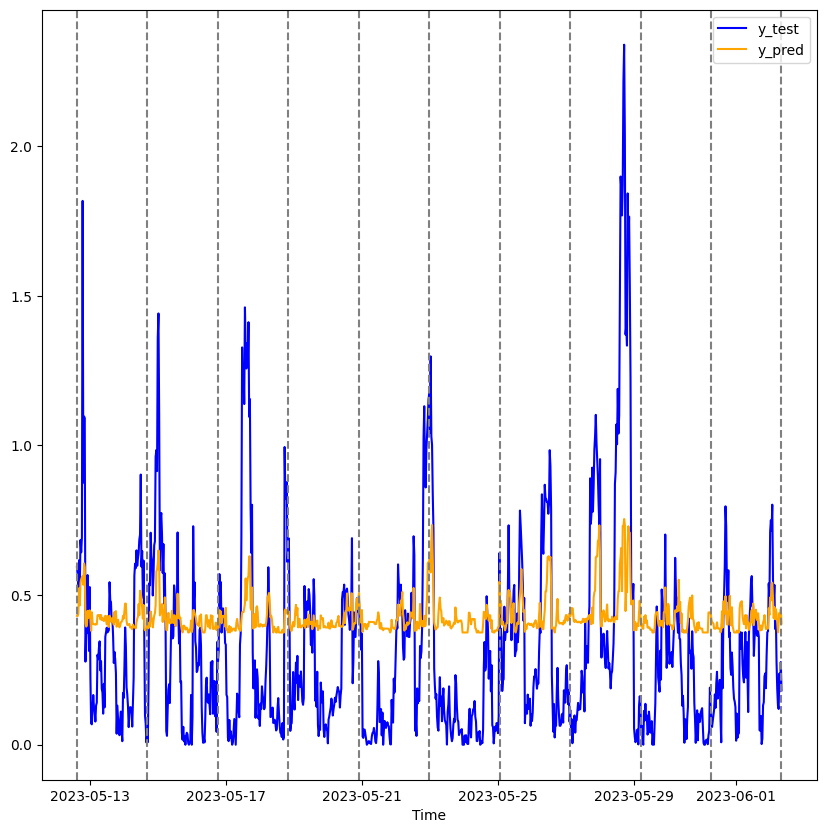

In [137]:
# plot Y_text with X axis time
mid_time = X_test.index.to_series().sample(1).values[0]
# start_time = X_test.index.to_series().sample(1).values[0]
# start_time = mid_time-pd.Timedelta('3 days')
# end_time = start_time+pd.Timedelta('3 days')

# start_time=X_test.index[-60]
# end_time=X_test.index[-1]

start_time=X_test.index[0]
end_time=X_test.index[-1]

plt.figure(figsize=(10, 10))
# plt.plot(y_pred[start_time:end_time], color='green', label='y_pred')
plt.plot(y_test[start_time:end_time], color='blue', label='y_test')
plt.plot(pd.DataFrame(data=y_pred, index=X_test.index, columns=['predictions']).predictions[start_time:end_time], color='orange', label='y_pred')
for i in range(11):
    plt.axvline(x=start_time + (end_time-start_time)*i/10, color='gray', linestyle='--')


plt.xlabel('Time')
plt.legend()
plt.show()


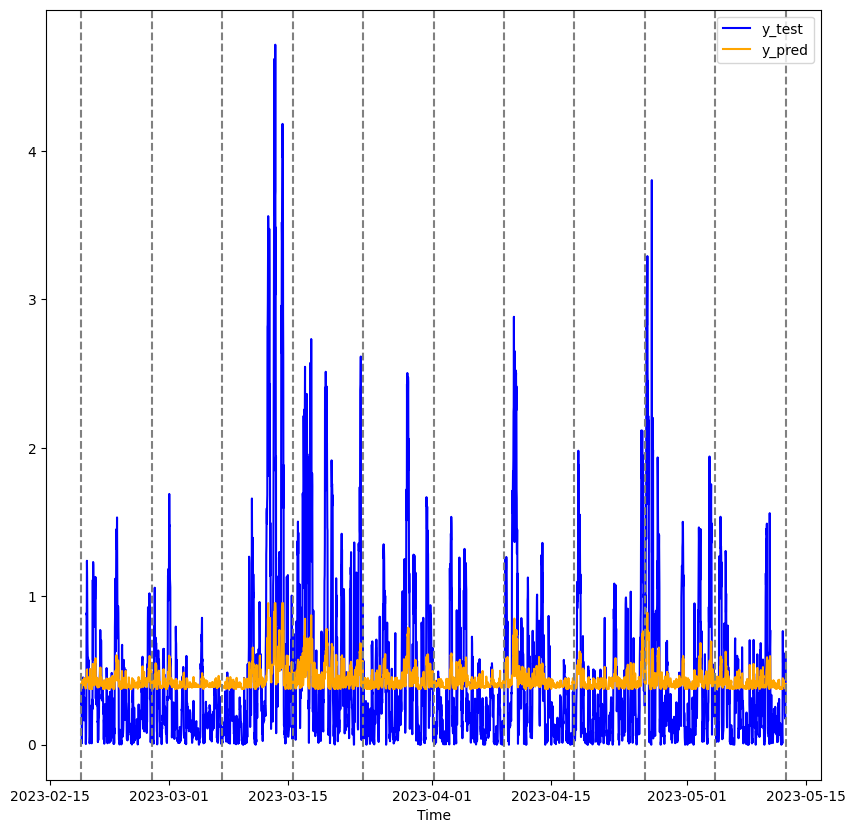

In [46]:
# plot Y_text with X axis time
# Make predictions on the test set
y_pred = model.predict(X_train)

y_pred_temp = y_pred[(y_train!=np.inf)]
y_test_temp = y_train[(y_train!=np.inf)]

mid_time = X_train.index.to_series().sample(1).values[0]
# start_time = X_train.index.to_series().sample(1).values[0]
# start_time = mid_time-pd.Timedelta('3 days')
# end_time = start_time+pd.Timedelta('3 days')

# start_time=X_test.index[-60]
# end_time=X_test.index[-1]

start_time=X_train.index[0]
end_time=X_train.index[-1]

plt.figure(figsize=(10, 10))
# plt.plot(y_pred[start_time:end_time], color='green', label='y_pred')
plt.plot(y_train[start_time:end_time], color='blue', label='y_test')
plt.plot(pd.DataFrame(data=y_pred, index=X_train.index, columns=['predictions']).predictions[start_time:end_time], color='orange', label='y_pred')
for i in range(11):
    plt.axvline(x=start_time + (end_time-start_time)*i/10, color='gray', linestyle='--')


plt.xlabel('Time')
plt.legend()
plt.show()


In [354]:
print(rr_order_block(X['Close'], X['High'], X['Low'], risk=0.01, ratio=3, lead=40).shape)
Y = rr_order_block(X['Close'], X['High'], X['Low'], risk=0.01, ratio=3, lead=40, ob_type='buy')
(Y).value_counts()


(9974,)


1.0    5145
0.0    3772
2.0    1057
dtype: int64

In [355]:
Y = Y.dropna()
Y=Y.loc[X_transformed.index]
X_transformed=X_transformed.loc[Y.index]

X_transformed = X_transformed.dropna()
import re


# X_transformed.loc[:,~((X_transformed.abs() == np.inf).sum()>0)].replace([np.inf, -np.inf], np.nan).dropna()
# .rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# .drop(columns=['Open', 'High', 'Low', 'Close'])
X_train, X_test, y_train, y_test = train_test_split(X_transformed[['trend_DPO_20',
 'trend_DMN_14',
 'momentum_PGO_14',
 'candles_close_Z_30_1',
 'momentum_KSTs_9'] + X_transformed.columns[X_transformed.columns.str.contains('EMA_20_50_100')].to_list()].rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)), Y, test_size=0.2, shuffle=False)

c:\Users\juanm\anaconda3\envs\bcs-trade-bot\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
Feature Importances: 
trend_DPO_20: 493
trend_DMN_14: 186
momentum_PGO_14: 418
candles_close_Z_30_1: 187
momentum_KSTs_9: 378
EMA_20_50_100__neg_1: 6
EMA_20_50_100_0: 1
EMA_20_50_100_1: 9
EMA_20_50_100__neg_1_lag_1: 3
EMA_20_50_100__neg_1_lag_2: 7
EMA_20_50_100__neg_1_lag_3: 3
EMA_20_50_100__neg_1_lag_4: 8
EMA_20_50_100__neg_1_lag_5: 8
EMA_20_50_100_0_lag_1: 9
EMA_20_50_100_0_lag_2: 5
EMA_20_50_100_0_lag_3: 1
EMA_20_50_100_0_lag_4: 13
EMA_20_50_100_0_lag_5: 19
EMA_20_50_100_1_lag_1: 16
EMA_20_50_100_1_lag_2: 3
EMA_20_50_100_1_lag_3: 9
EMA_20_50_100_1_lag_4: 12
EMA_20_50_100_1_lag_5: 6


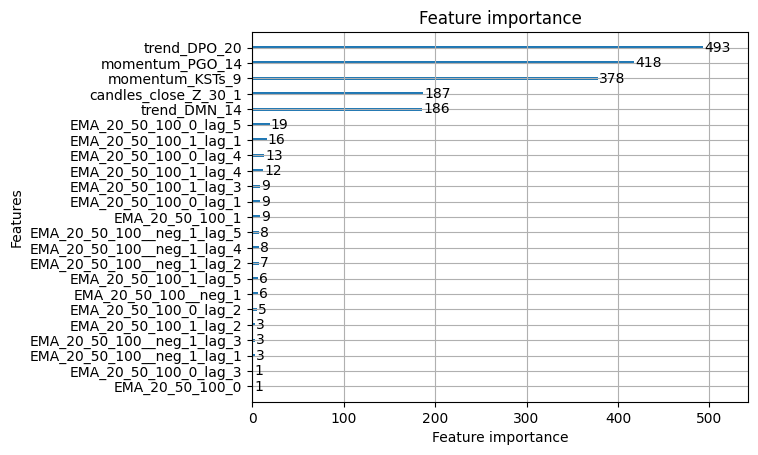

In [356]:
lgb_train = lgb.Dataset(X_train.reset_index(drop=True), label=y_train.reset_index(drop=True), categorical_feature=X_train.columns[X_train.columns.str.contains('k_crossover_d') | X_train.columns.str.contains('k_crossunder_d')].to_list())


# Specify the configuration of the model
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 3,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the model
model = lgb.train(params,
                lgb_train,
                num_boost_round=20)
# Predict on the test set
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = np.argmax(y_pred, axis=1)

# Print the feature importances
print('Feature Importances: ')
for feature_name, importance_score in zip(X_train.columns, model.feature_importance()):
    print(f'{feature_name}: {importance_score}')

# Plotting feature importances
lgb.plot_importance(model)
plt.show()

Accuracy: 0.66
Precision: 0.64
Recall: 0.54
F1 Score: 0.56
ROC AUC: 0.77


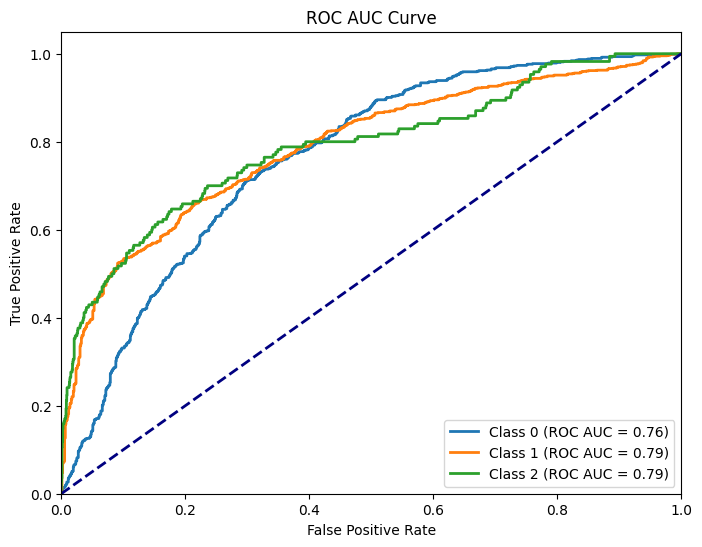

In [357]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred.argmax(axis=1))
precision = precision_score(y_test, y_pred.argmax(axis=1), average='macro')
recall = recall_score(y_test, y_pred.argmax(axis=1), average='macro')
f1 = f1_score(y_test, y_pred.argmax(axis=1), average='macro')
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovo')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

# Plot ROC AUC curves for each class (for multiclass)
plt.figure(figsize=(8, 6))
for i in range(y_pred.shape[1]):
    fpr, tpr, _ = roc_curve(y_test, y_pred[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (ROC AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()


In [358]:
X_test.index.min() - X_test.index.max()

Timedelta('-42 days +11:30:00')

In [359]:
X_test.index.min(), X_test.index.max()

(Timestamp('2023-04-21 19:30:00'), Timestamp('2023-06-02 08:00:00'))

In [360]:
(X.loc[X_test.index[-1]].Close - X.loc[X_test.index[0]].Close)/X.loc[X_test.index[-1]].Close

-0.006459736681520119

In [361]:
129/75

1.72

In [362]:
60/36

1.6666666666666667

In [ ]:
# context de volumen
# market context en 1 hora / 4 h
# Parametrizar
# velas en 15m o 30m
# qué tan seguidas son las entradas?
# graficar entradas y R:R

<Axes: xlabel='Timestamp'>

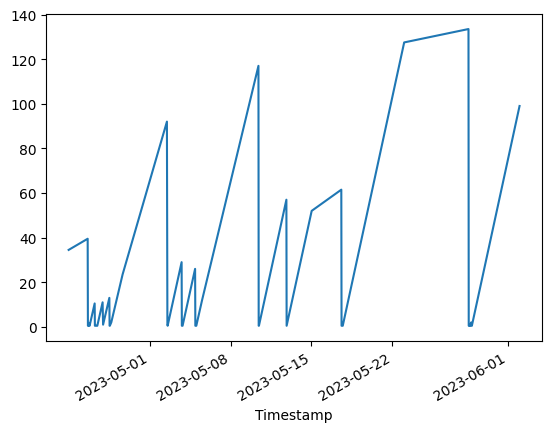

In [381]:
(X_test[np.argmax(y_pred, axis=1)==2].index.to_series().diff().dt.total_seconds()/60/60).plot()

In [363]:
# print confusion matrix with column labels
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
print(cm)

[[432 301  22]
 [215 849   5]
 [ 52  75  43]]


In [305]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

# Make predictions on the test set
y_pred = model.predict_proba(X_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred.argmax(axis=1))
precision = precision_score(y_test, y_pred.argmax(axis=1), average='macro')
recall = recall_score(y_test, y_pred.argmax(axis=1), average='macro')
f1 = f1_score(y_test, y_pred.argmax(axis=1), average='macro')
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovo')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

# Plot ROC AUC curves for each class (for multiclass)
plt.figure(figsize=(8, 6))
for i in range(y_pred.shape[1]):
    fpr, tpr, _ = roc_curve(y_test, y_pred[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (ROC AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()


AttributeError: 'Booster' object has no attribute 'predict_proba'